In [1]:
import time, warnings
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from numpy import newaxis # 차원을 분해한 후 한 단계 추가

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
data_file = 'sp500.csv' #추세그래프 그리기. 
df = pd.read_csv(data_file, names=['price'])

In [3]:
len(df)

4171

In [4]:
# price = df['price'].tolist()
price = df[['price']].values #tolist()




window_size = 50

In [5]:
type(price)

numpy.ndarray

In [6]:
## 훈련, 검증, 테스트용 데이터 작성
## 과거 30일분의 주가로부터 당일의 주가 계산
def data_split(data, start, end, window_size ):
    length = abs(start - end) - window_size
    
    #초기 선언
    X=np.zeros((length, window_size)) # 240 이면 30이다?
    y=np.zeros((length, 1))
   
    for i in range(length):
        j = start + i 
        k = j + window_size
        X[i] = data[j:k, 0]
        y[i] = data[k,0]
    
    return X, y 

In [7]:
len(price)
print(price[3500])

[1800.900024]


In [8]:
## 훈련, 검증, 테스트용 데이터
(X_train, y_train) = data_split(price, 0, 3000, window_size) #트레인 데이터 !!!! 는 과거 300일부터 과거 60일까지 !!!
(X_valid, y_valid) = data_split(price, 3000, 3700, window_size)
(X_test, y_test) = data_split(price, 3700, 4171, window_size)
print(X_test[-1])

[2040.040039 2052.320068 2048.040039 2076.060059 2090.540039 2090.100098
 2099.060059 2096.949951 2099.330078 2105.26001  2099.129883 2109.409912
 2112.129883 2119.120117 2115.47998  2096.070068 2079.060059 2075.320068
 2071.5      2077.98999  2071.219971 2083.25     2088.899902 2085.449951
 2113.320068 2037.410034 2000.540039 2036.089966 2070.77002  2098.860107
 2102.949951 2088.550049 2099.72998  2097.899902 2129.899902 2137.159912
 2152.139893 2152.429932 2163.75     2161.73999  2166.889893 2163.780029
 2173.02002  2165.169922 2175.030029 2168.47998  2169.179932 2166.580078
 2170.060059 2173.600098]


In [9]:
print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

print(X_test.shape)
print(y_test.shape)

# print(X_test[-50])

(2950, 50)
(2950, 1)
(650, 50)
(650, 1)
(421, 50)
(421, 1)


In [10]:
## 표준화
## X만 차원을 변환 (2차원 -> 3차원)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_valid_std =scaler.fit_transform(X_valid)
X_test_std =scaler.fit_transform(X_test)

In [11]:
# scaler transform 사용


y_train_std = scaler.fit_transform(y_train)
y_valid_std =scaler.fit_transform(y_valid)
y_test_std =scaler.fit_transform(y_test)

In [12]:
# reshape (data개수, sequence, feature개수)
# reshape(-1(지금가지고 있는 값 그대로 쓰겠다),30(window_size를 위에서 30으로 지정함.),1(종가 하나만 다루므로 1))

X_valid_std=X_valid_std.reshape(-1, window_size, 1)
X_test_std=X_test_std.reshape(-1, window_size, 1)
X_train_std=X_train_std.reshape(-1, window_size, 1)

X_train_std

array([[[ 1.42769436],
        [ 1.12902949],
        [ 1.14415206],
        ...,
        [ 1.13332251],
        [ 1.07167714],
        [ 0.93929076]],

       [[ 1.12807437],
        [ 1.14347804],
        [ 1.15135099],
        ...,
        [ 1.07119108],
        [ 0.93886807],
        [ 1.11837347]],

       [[ 1.14251812],
        [ 1.15067543],
        [ 1.35561231],
        ...,
        [ 0.93840847],
        [ 1.11791896],
        [ 1.4784387 ]],

       ...,

       [[ 0.06850246],
        [-0.12066299],
        [-0.32011355],
        ...,
        [-0.14946588],
        [ 0.0346582 ],
        [ 0.04925059]],

       [[-0.12120319],
        [-0.32047599],
        [-0.28320472],
        ...,
        [ 0.03437886],
        [ 0.04898603],
        [ 0.33027873]],

       [[-0.32094984],
        [-0.28357502],
        [-0.14072744],
        ...,
        [ 0.04870383],
        [ 0.32996424],
        [ 0.31735912]]])

In [13]:
## 훈련 RNN (model -> LSTM)
# Input -> LSTM(128) -> Dense
# compile -> loss=mse, optimizer=adam, metrics = 'accuracy'




i = Input(shape=(window_size, 1))

x = LSTM(128)(i)
x = Dense(1)(x)
model = Model(i,x)

model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])


model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Model 학습, epochs = 10


r=model.fit(X_train_std, y_train_std, epochs=100, batch_size=64, shuffle=True, validation_data=((X_valid_std, y_valid_std)))

Train on 2950 samples, validate on 650 samples
Epoch 1/100
2950/2950 [==============================] - 7s 2ms/sample - loss: 0.1460 - accuracy: 0.0000e+00 - val_loss: 0.0118 - val_accuracy: 0.0000e+00
Epoch 2/100
2950/2950 [==============================] - 1s 263us/sample - loss: 0.0217 - accuracy: 0.0000e+00 - val_loss: 0.0111 - val_accuracy: 0.0000e+00
Epoch 3/100
2950/2950 [==============================] - 1s 268us/sample - loss: 0.0199 - accuracy: 0.0000e+00 - val_loss: 0.0094 - val_accuracy: 0.0000e+00
Epoch 4/100
2950/2950 [==============================] - 1s 262us/sample - loss: 0.0182 - accuracy: 0.0000e+00 - val_loss: 0.0088 - val_accuracy: 0.0000e+00
Epoch 5/100
2950/2950 [==============================] - 1s 262us/sample - loss: 0.0168 - accuracy: 0.0000e+00 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 6/100
2950/2950 [==============================] - 1s 265us/sample - loss: 0.0160 - accuracy: 0.0000e+00 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 7/100
2

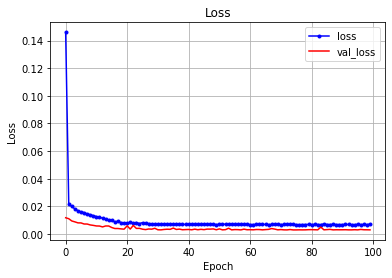

In [15]:
plt.title('Loss')
plt.plot(r.history['loss'],'b',marker='.', label = 'loss')
plt.plot(r.history['val_loss'],'r', label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

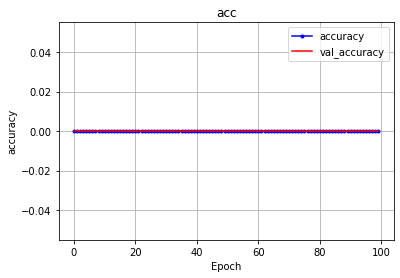

In [16]:
plt.title('acc')
plt.plot(r.history['accuracy'],'b',marker='.', label = 'accuracy')
plt.plot(r.history['val_accuracy'],'r', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')

plt.legend()
plt.grid(True)
plt.show()

In [17]:
p = model.predict(X_test_std)

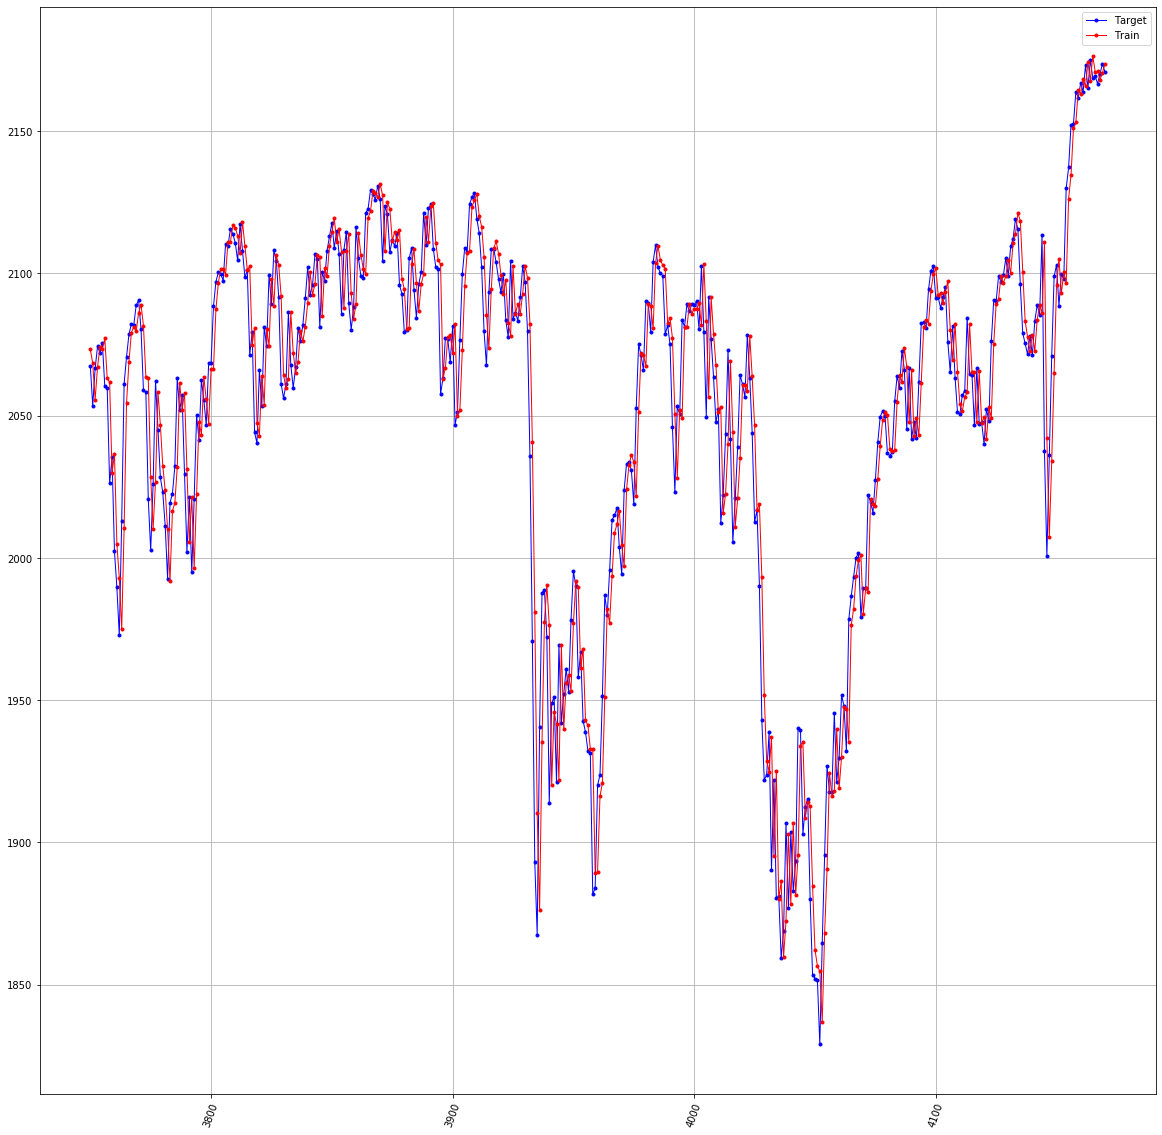

In [18]:
## 예측치
p = model.predict(X_test_std)
df_predict_std = pd.DataFrame(p, columns=['정확도'])

## 예측치 그래프로 표시
predict = scaler.inverse_transform(df_predict_std['정확도'].values)

pre_date = df.index[-len(y_test):].values
plt.figure(figsize=(20, 20))
plt.plot(pre_date, y_test, 'b', marker='.', label='Target', linewidth=1) # 정답 데이터. 
plt.plot(pre_date, predict, 'r', marker='.', label='Train', linewidth=1) #예측한 데이터
plt.xticks(rotation=70) # x축 이름들 각도. 
plt.grid()
plt.legend()
plt.show()

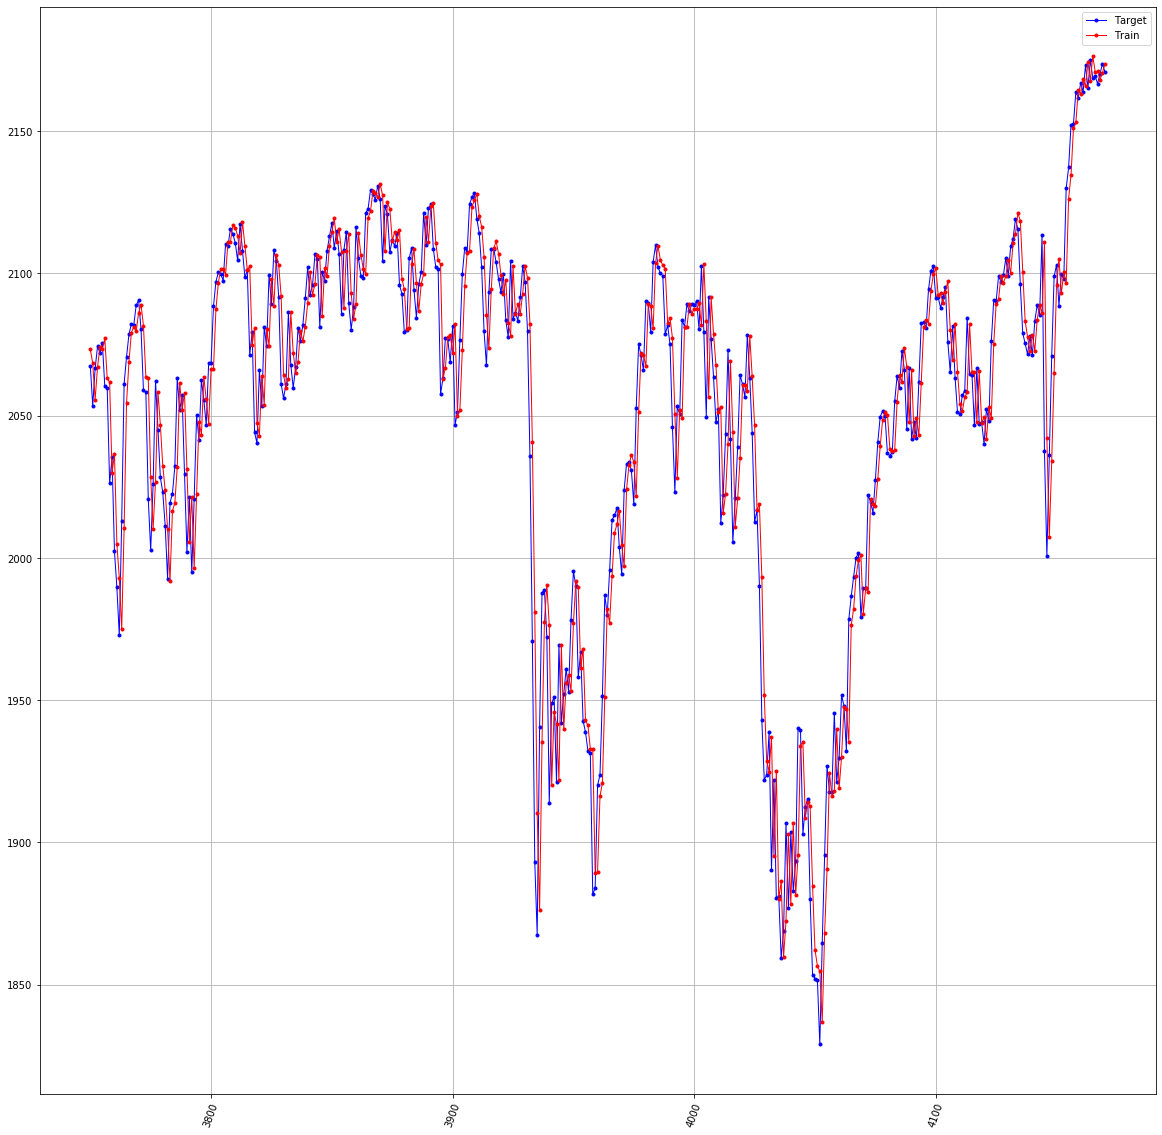

In [19]:
## 예측치
p = model.predict(X_test_std)
df_predict_std = pd.DataFrame(p, columns=['정확도'])

## 예측치 그래프로 표시
predict = scaler.inverse_transform(df_predict_std['정확도'].values)

pre_date = df.index[-len(y_test):].values
plt.figure(figsize=(20, 20))
plt.plot(pre_date, y_test, 'b', marker='.', label='Target', linewidth=1) # 정답 데이터. 
plt.plot(pre_date, predict, 'r', marker='.', label='Train', linewidth=1) #예측한 데이터
plt.xticks(rotation=70) # x축 이름들 각도. 
plt.grid()
plt.legend()
plt.show()